# **Imports and Checks**

In [ ]:
# by Manuel

import numpy as np 
import matplotlib.pyplot as plt
import torch

from optiland.optic import Optic
from optiland.materials import Material
from optiland.apodization import GaussianApodization
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.analysis.intensity import RadiantIntensity
from optiland.physical_apertures import RadialAperture, RectangularAperture
import optiland.backend as be
from optiland.ml import OpticalSystemModule

be.set_backend("torch")
be.set_precision("float32")
be.grad_mode.enable()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Optiland backend successfully set to: {be.get_backend()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch precision set to: {torch.get_default_dtype()}")

# --- Plotting Style (Publication-quality with Latin Modern fonts) ---
plt.style.use("default")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": [
            "Latin Modern Roman",
            "Latin Modern Math",
            "Computer Modern Roman",
            "DejaVu Serif",
        ],
        "mathtext.fontset": "cm",  # Computer Modern for math (similar to Latin Modern)
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "axes.linewidth": 1.2,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "axes.grid": True,
        "grid.linestyle": ":",
        "grid.alpha": 0.6,
        "figure.figsize": (10, 6),
        "text.usetex": False,  # Set to True if you have LaTeX installed for native Latin Modern
    }
)

Optiland backend successfully set to: torch
PyTorch version: 2.10.0+cu126
CUDA available: True
PyTorch precision set to: torch.float32


## **My Backend**

In [ ]:
from dataclasses import dataclass
from typing import Literal, Optional, Union

import torch 

# Type alias
ArrayLike = Union[float, int, np.ndarray, "torch.Tensor"]

# dataclass generates __init__ and other methods automatically like __repr__ and __eq__
@dataclass(frozen=True)
class Backend:
    '''
    Class to handle different computational backends (NumPy and PyTorch).
    
    by Ziyi Xiong, 2026/1
    
    Attributes:
        name (Literal["numpy", "torch"]): The name of the backend to use.
        device (Literal["cpu", "cuda"]): The device to use for PyTorch tensors.
        dtype (Optional[torch.dtype]): The data type for PyTorch tensors.
    '''
    # Necessary to list attributes at class level for dataclass
    name: Literal["numpy", "torch"] = "numpy"
    device: Literal["cpu", "cuda"] = "cpu"
    dtype: Optional["torch.dtype"] = None  

    # dataclass automatically generates __init__, but we need to customize post-init, specially for dataclass
    def __post_init__(self):
        if self.name == "torch":
            if torch is None:
                raise ImportError("Backend(name='torch') requested but torch is not installed.")
            # frozen=True prevents setting attributes normally, so use object.__setattr__
            object.__setattr__(self, "dtype", self.dtype if self.dtype is not None else torch.float32)

    @property
    def is_torch(self) -> bool:
        return self.name == "torch"

    def tensor(self, x: ArrayLike) -> ArrayLike:
        if not self.is_torch:
            return x
        assert torch is not None
        if isinstance(x, torch.Tensor):
            # Move to the correct device and dtype
            return x.to(device=self.device, dtype=self.dtype)  
        # Convert numpy array or scalar to torch tensor on the correct device and dtype
        return torch.tensor(x, device=self.device, dtype=self.dtype)  

    def sqrt(self, x: ArrayLike) -> ArrayLike:
        if not self.is_torch:
            return np.sqrt(x)
        assert torch is not None
        t = self.tensor(x)
        assert isinstance(t, torch.Tensor) 
        return torch.sqrt(t)

    def exp(self, x: ArrayLike) -> ArrayLike:
        if not self.is_torch:
            return np.exp(x)
        assert torch is not None
        t = self.tensor(x)
        assert isinstance(t, torch.Tensor)  
        return torch.exp(t)

    def abs(self, x: ArrayLike) -> ArrayLike:
        if not self.is_torch:
            return np.abs(x)
        assert torch is not None
        t = self.tensor(x)
        assert isinstance(t, torch.Tensor)  
        return torch.abs(t)

    def scalar(self, x: ArrayLike) -> float:
        if not self.is_torch:
            return float(x)
        assert torch is not None
        t = self.tensor(x)
        assert isinstance(t, torch.Tensor)  
        return float(t.detach().cpu().item())
    
    def meshgrid(self, X: ArrayLike, Y: ArrayLike, indexing: Literal['xy', 'ij'] ='xy'):
        if not self.is_torch:
            if isinstance(X, torch.Tensor) or isinstance(Y, torch.Tensor):
                raise TypeError("meshgrid received torch.Tensor inputs but backend is numpy.")
            return np.meshgrid(X, Y, indexing=indexing)
        assert torch is not None
        X = self.tensor(X)
        Y = self.tensor(Y)
        assert isinstance(X, torch.Tensor)
        assert isinstance(Y, torch.Tensor)
        return torch.meshgrid(X, Y, indexing=indexing)
    
    def linspace(self, start: ArrayLike, end: ArrayLike, steps: int) -> ArrayLike:
        if not self.is_torch:
            return np.linspace(start, end, steps)
        assert torch is not None
        start_t = self.tensor(start)
        end_t = self.tensor(end)
        assert isinstance(start_t, torch.Tensor)
        assert isinstance(end_t, torch.Tensor)
        return torch.linspace(start_t, end_t, steps, device=self.device, dtype=self.dtype)
    
    def to_numpy(self, x: ArrayLike) -> np.ndarray:
        if not self.is_torch:
            if isinstance(x, np.ndarray):
                return x
            else:
                return np.array(x)
        assert torch is not None
        t = self.tensor(x)
        assert isinstance(t, torch.Tensor)
        return t.detach().cpu().numpy()
        

# **Initial Parameters**

In [ ]:
from pprint import pprint

# ANALYSIS CONFIGURATION by Manuel

EPSILON = 1e-15 # Global small constant to prevent division by zero

STD_EVAL = dict(
    top_hat_radius=7.50,  # R0 (mm) (1/e^2 irradiance level)
    num_bins_analysis=201,  # 201 x 201
    num_analysis_rays=1_000_000,  # shared rays
    peak_irradiance=6.65e-3,  # W/mm^2 (0.00060)
    falloff_steepness=16,  # p
    alpha_threshold=0.999,  # rigorous mask threshold
    wavelength_um=1.55,
    # Source parameters
    mfd_um=10.4,  # Mode field diameter in µm (MFD = 2 * w0)
    divergence_deg_1_e2=(1.55 / (np.pi * 5.2))
    * (180 / np.pi)
    * 2,  # Full divergence angle (1/e²) in degrees
)

OPT_COMMON = dict(
    num_bins_optimization=64,
    num_bins_intensity=101,  # Can be different from irradiance bins
    num_optimization_rays=2**14,  # =16384 rays, required by Sobol sampling
    total_steps=300,
    forbes_norm_radius=18.75,
)

A_SPEC = dict(
    # schedules (match across A1-Sched and A2-StagedMix)
    num_coeffs_A1_fixed=6,
    num_coeffs_stage1=4,  # staged cap: 4 → 6
    num_coeffs_stage2=6,  # IMPORTANT: CAREFUL WITH THE TOTAL NUMBER OF COEFFICIENTS!!!
    lr_high=5e-2,  # two-phase LR (High -> Low)
    lr_low=0.015,
    switch_step=570,  # first 225 steps = Stage-1
    steps_low=130,  # last 75 steps
    beta_mix=0.5,  # Stage-2 mixing (A2)
    a1_weights=(0.5, 0.5),  # default for A1
)

B_SPEC = dict(
    w_mfg_sweep=[1e-2, 3e-2, 1e-1, 3e-1, 1.0],
    b1_cap=(A_SPEC["num_coeffs_stage1"], A_SPEC["num_coeffs_stage2"]),  # 4→6
    b2_cap=(6, 8),  # 6→8
)

C_SPEC = dict(
    max_coeffs=6,
    initial_coeffs=2,
    adapt_interval=50,
    add_k=1,
    grad_thresh=1e-2,
    w_mfg_sweep=[
        1e-2,
        3e-2,
        1e-1,
        3e-1,
        1.0,
    ],  # [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0],
)

EVAL_LOGGING = dict(
    eval_every=25,  # standardized L_optical logs during training
)

pprint(STD_EVAL)

{'alpha_threshold': 0.999,
 'divergence_deg_1_e2': 10.872542398543171,
 'falloff_steepness': 16,
 'mfd_um': 10.4,
 'num_analysis_rays': 1000000,
 'num_bins_analysis': 201,
 'peak_irradiance': 0.00665,
 'top_hat_radius': 7.5,
 'wavelength_um': 1.55}


# **Build System**

## **Beam Shaper Class**

In [4]:
class ForbesDualLensBeamShaper(Optic):   
    """
    Creates a dual-lens beam shaper system with Forbes Q-bfs surfaces.

    by Manuel, modified by Ziyi Xiong
    
    Surface layout:
        0: Object plane
        1: Air gap
        2: Lens 1 front (flat, stop)
        3: Lens 1 back (Forbes Q-bfs) <-- Optimizable
        4: Lens 2 front (flat)
        5: Lens 2 back (Forbes Q-bfs) <-- Optimizable
        6: Detector plane
    """
    
    def __init__(self, num_coeffs: int = 10):
        super().__init__()
    
        lens = Optic()

        # Aperture & Field setup
        lens.set_aperture(aperture_type="objectNA", value=0.15)
        lens.set_field_type(field_type="angle")
        lens.add_field(y=0)
        lens.add_wavelength(value=1.55, is_primary=True)

        # Materials
        D_K9 = Material("D-K9", reference="cdgm")
        D_ZLAF52LA = Material("D-ZLAF52LA", reference="cdgm")

        # Forbes surface parameters
        conic_S2 = -4.428
        conic_S4 = 0.038
        norm_radius_S2 = 8.5 * 1.25
        norm_radius_S4 = 12.5 * 1.25
        
        # Initialize coefficients to zero
        coeffs_S2 = {i: 0.0 for i in range(num_coeffs)}
        coeffs_S4 = {i: 0.0 for i in range(num_coeffs)}

        # Physical apertures
        ap1 = RadialAperture(8.5)  # Lens 1 semi-clear aperture
        ap2 = RadialAperture(12.5)  # Lens 2 semi-clear aperture
        apt_detector = RectangularAperture(-1.5 * 7.5, 1.5 * 7.5, -1.5 * 7.5, 1.5 * 7.5)

        # Build surfaces
        lens.add_surface(index=0, thickness=0.0)  # Object
        lens.add_surface(index=1, thickness=26.5)  # Air gap
        lens.add_surface(  # Lens 1 front (flat, stop)
            index=2,
            thickness=4.0,
            radius=be.inf,
            conic=0.0,
            material=D_K9,
            aperture=ap1,
            is_stop=True,
        )
        lens.add_surface(  # Lens 1 back (Forbes Q-bfs)
            index=3,
            radius=100000.0,
            thickness=25.0,
            surface_type="forbes_qbfs",
            conic=0.0,  # Avoid exactly -1.0 (parabola) - causes NaN gradients in ray intersection
            radial_terms=coeffs_S2,
            norm_radius=norm_radius_S2,
            aperture=ap1,
        )
        lens.add_surface(  # Lens 2 front (flat)
            index=4,
            radius=be.inf,
            thickness=7.0,
            material=D_ZLAF52LA,
            aperture=ap2,
        )
        lens.add_surface(  # Lens 2 back (Forbes Q-bfs)
            index=5,
            radius=-10000.0,  # -43
            thickness=10.0,
            surface_type="forbes_qbfs",
            conic=0.0,
            radial_terms=coeffs_S4,
            norm_radius=norm_radius_S4,
            aperture=ap2,
        )
        lens.add_surface(index=6, aperture=apt_detector)  # Detector

## **Gaussian Source Class**

In [5]:
from optiland.rays import RealRays
from scipy.stats.qmc import Sobol
from optiland.sources.base import BaseSource

class ExtendedGaussianSource(BaseSource):
    """
    Generates a high-quality, extended Gaussian beam with both spatial and
    angular distributions, using Sobol sequences.
    
    By Manuel, modified by Ziyi Xiong
    """

    def __init__(
        self,
        mfd_um: float,
        divergence_deg_1_e2: float,
        wavelength_um: float,
        total_power: float = 1.0,
        device: str = "cpu",
        is_point_source: bool = False,
        position: tuple[float, float, float] = (0.0, 0.0, 0.0) # newly added
    ):
        super().__init__(position = position) # newly added
        
        self.wavelength = wavelength_um
        self.total_power = total_power
        self.device = device
        self.sqrt2 = torch.tensor(np.sqrt(2.0), dtype=torch.float32, device=self.device)
        self.is_point_source = is_point_source

        # Spatial sigma for importance sampling
        w0_um = mfd_um / 2.0  # w₀ is the 1/e² radius
        self.sigma_spatial_mm = (w0_um * 1e-3) / 2.0

        # Angular sigma for importance sampling
        theta_rad = np.radians(divergence_deg_1_e2 / 2.0)
        self.sigma_angular_rad = theta_rad / 2.0

    def generate_rays(self, num_rays: int) -> RealRays:
        if num_rays <= 0:
            raise ValueError("num_rays must be a positive integer.")

        # Round up to nearest power of 2 (required for Sobol sampling)
        num_samples = 1 << (num_rays - 1).bit_length()
        sampler = Sobol(d=4, scramble=True)
        u_numpy = sampler.random(n=num_samples)
        u = torch.from_numpy(u_numpy).float().to(self.device)

        if self.is_point_source:
            # For point source, set spatial coordinates to zero
            x_start = torch.zeros(num_samples, device=self.device)
            y_start = torch.zeros(num_samples, device=self.device)
        else:
            # Convert uniform samples to a Gaussian distribution in phase space
            x_start = self.sigma_spatial_mm * self.sqrt2 * torch.erfinv(2 * u[:, 0] - 1)
            y_start = self.sigma_spatial_mm * self.sqrt2 * torch.erfinv(2 * u[:, 1] - 1)

        # sample non-paraxial angles
        theta_x = self.sigma_angular_rad * self.sqrt2 * torch.erfinv(2 * u[:, 2] - 1)
        theta_y = self.sigma_angular_rad * self.sqrt2 * torch.erfinv(2 * u[:, 3] - 1)
        tau_x = torch.tan(theta_x)
        tau_y = torch.tan(theta_y)
        # direction cosines for tracing in optiland, taken from slopes
        N_initial = 1.0 / torch.sqrt(1.0 + tau_x**2 + tau_y**2)
        L_initial = tau_x * N_initial
        M_initial = tau_y * N_initial

        num_valid_rays = L_initial.shape[0]

        if num_valid_rays == 0:
            raise ValueError("No valid rays generated. Try increasing num_rays.")

        print(f"Generated {num_valid_rays} valid rays (from {num_samples} samples).")

        z_start = torch.zeros(num_valid_rays, device=self.device)

        unnormalized_power = torch.ones_like(N_initial)
        total_unnormalized_power = torch.sum(unnormalized_power)

        if total_unnormalized_power > 1e-9:
            normalization_factor = self.total_power / total_unnormalized_power
        else:
            normalization_factor = 0.0

        intensity = unnormalized_power * normalization_factor
        wavelength = torch.full((num_valid_rays,), self.wavelength, device=self.device)

        return RealRays(
            x=x_start.detach(),
            y=y_start.detach(),
            z=z_start.detach(),
            L=L_initial.detach(),
            M=M_initial.detach(),
            N=N_initial.detach(),
            intensity=intensity,
            wavelength=wavelength,
        )
    
    # newly added
    def __repr__(self) -> str:
        return (
            "ExtendedGaussianSource("
            f"wavelength_um={self.wavelength}, total_power={self.total_power}, "
            f"sigma_spatial_mm={self.sigma_spatial_mm}, sigma_angular_rad={self.sigma_angular_rad}, "
            f"device={self.device!r}, is_point_source={self.is_point_source}, "
            f"position=({self.cs.x}, {self.cs.y}, {self.cs.z})"
            ")"
        )

## **Super Gaussian Class**

In [6]:
from typing import Literal, Optional
import torch

class SuperGaussianIrradiance:
    '''
         A class to represent a Super-Gaussian irradiance profile.

         By Ziyi Xiong 2026/1

         Args:
             amplitude (float): The peak value of the Super-Gaussian.
             center (float): The center position of the Super-Gaussian.
             width (float): The width parameter controlling the spread.
             order (int): The order of the Super-Gaussian, determining the steepness.
             max_coord (float): The maximum coordinate value for sampling.
             num_samples (int): The number of samples to generate.

         '''
    
    def __init__(self, 
                 peak_irradiance: float = 1, 
                 flattop_radius: float = 1, 
                 steepness: float = 2, 
                 max_coord: float = 10, 
                 num_samples: int = 1000,
                 backend: Literal['numpy', 'torch'] = 'numpy',
                 device: Literal['cpu', 'cuda'] = 'cpu',
                 dtype: Optional["torch.dtype"] = None
                 ):
        self.be = Backend(name=backend, device=device, dtype=dtype)
        
        self.peak_irradiance = self.be.tensor(peak_irradiance)
        self.flattop_radius = self.be.tensor(flattop_radius) 
        self.steepness = self.be.tensor(steepness)
        self.max_coord = self.be.tensor(max_coord)
        self.num_samples = int(num_samples)
        self.coords = self.be.linspace(-self.max_coord, self.max_coord, self.num_samples)
        
    def profile(self) -> ArrayLike:
        X, Y = self.be.meshgrid(self.coords, self.coords, indexing='xy')
        R = self.be.sqrt(X**2 + Y**2)
        shape = self.be.exp(-2 * (R / self.flattop_radius) ** self.steepness)
        return self.peak_irradiance * shape
    
    def profile_1d(self) -> ArrayLike:
        X = self.coords
        shape = self.be.exp(-2 * (X / self.flattop_radius) ** self.steepness)
        return self.peak_irradiance * shape
    
    def plot_cross_section(self):
        y_values = self.profile_1d()
        
        X_np = self.be.to_numpy(self.coords)
        y_np = self.be.to_numpy(y_values)
        
        plt.figure(figsize=(8, 5))
        plt.plot(X_np, y_np, label=f'Super-Gaussian Irradiance (order={self.be.scalar(self.steepness)})')
        plt.title('Super-Gaussian Irradiance Profile')
        plt.xlabel('x')
        plt.ylabel('Irradiance')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def plot_2d(self):
        irradiance = self.profile()
        
        X_np = self.be.to_numpy(self.coords)
        Y_np = self.be.to_numpy(self.coords)
        I_np = self.be.to_numpy(irradiance)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(I_np, extent=(-self.be.scalar(self.max_coord), self.be.scalar(self.max_coord), 
                                 -self.be.scalar(self.max_coord), self.be.scalar(self.max_coord)),
                   origin='lower', cmap='viridis')
        plt.colorbar(label='Irradiance')
        plt.title('Super-Gaussian Irradiance Profile (2D)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

## **Standardized Assets**

### **Source**

Generated 8192 valid rays (from 8192 samples).
Generated 1048576 valid rays (from 1048576 samples).


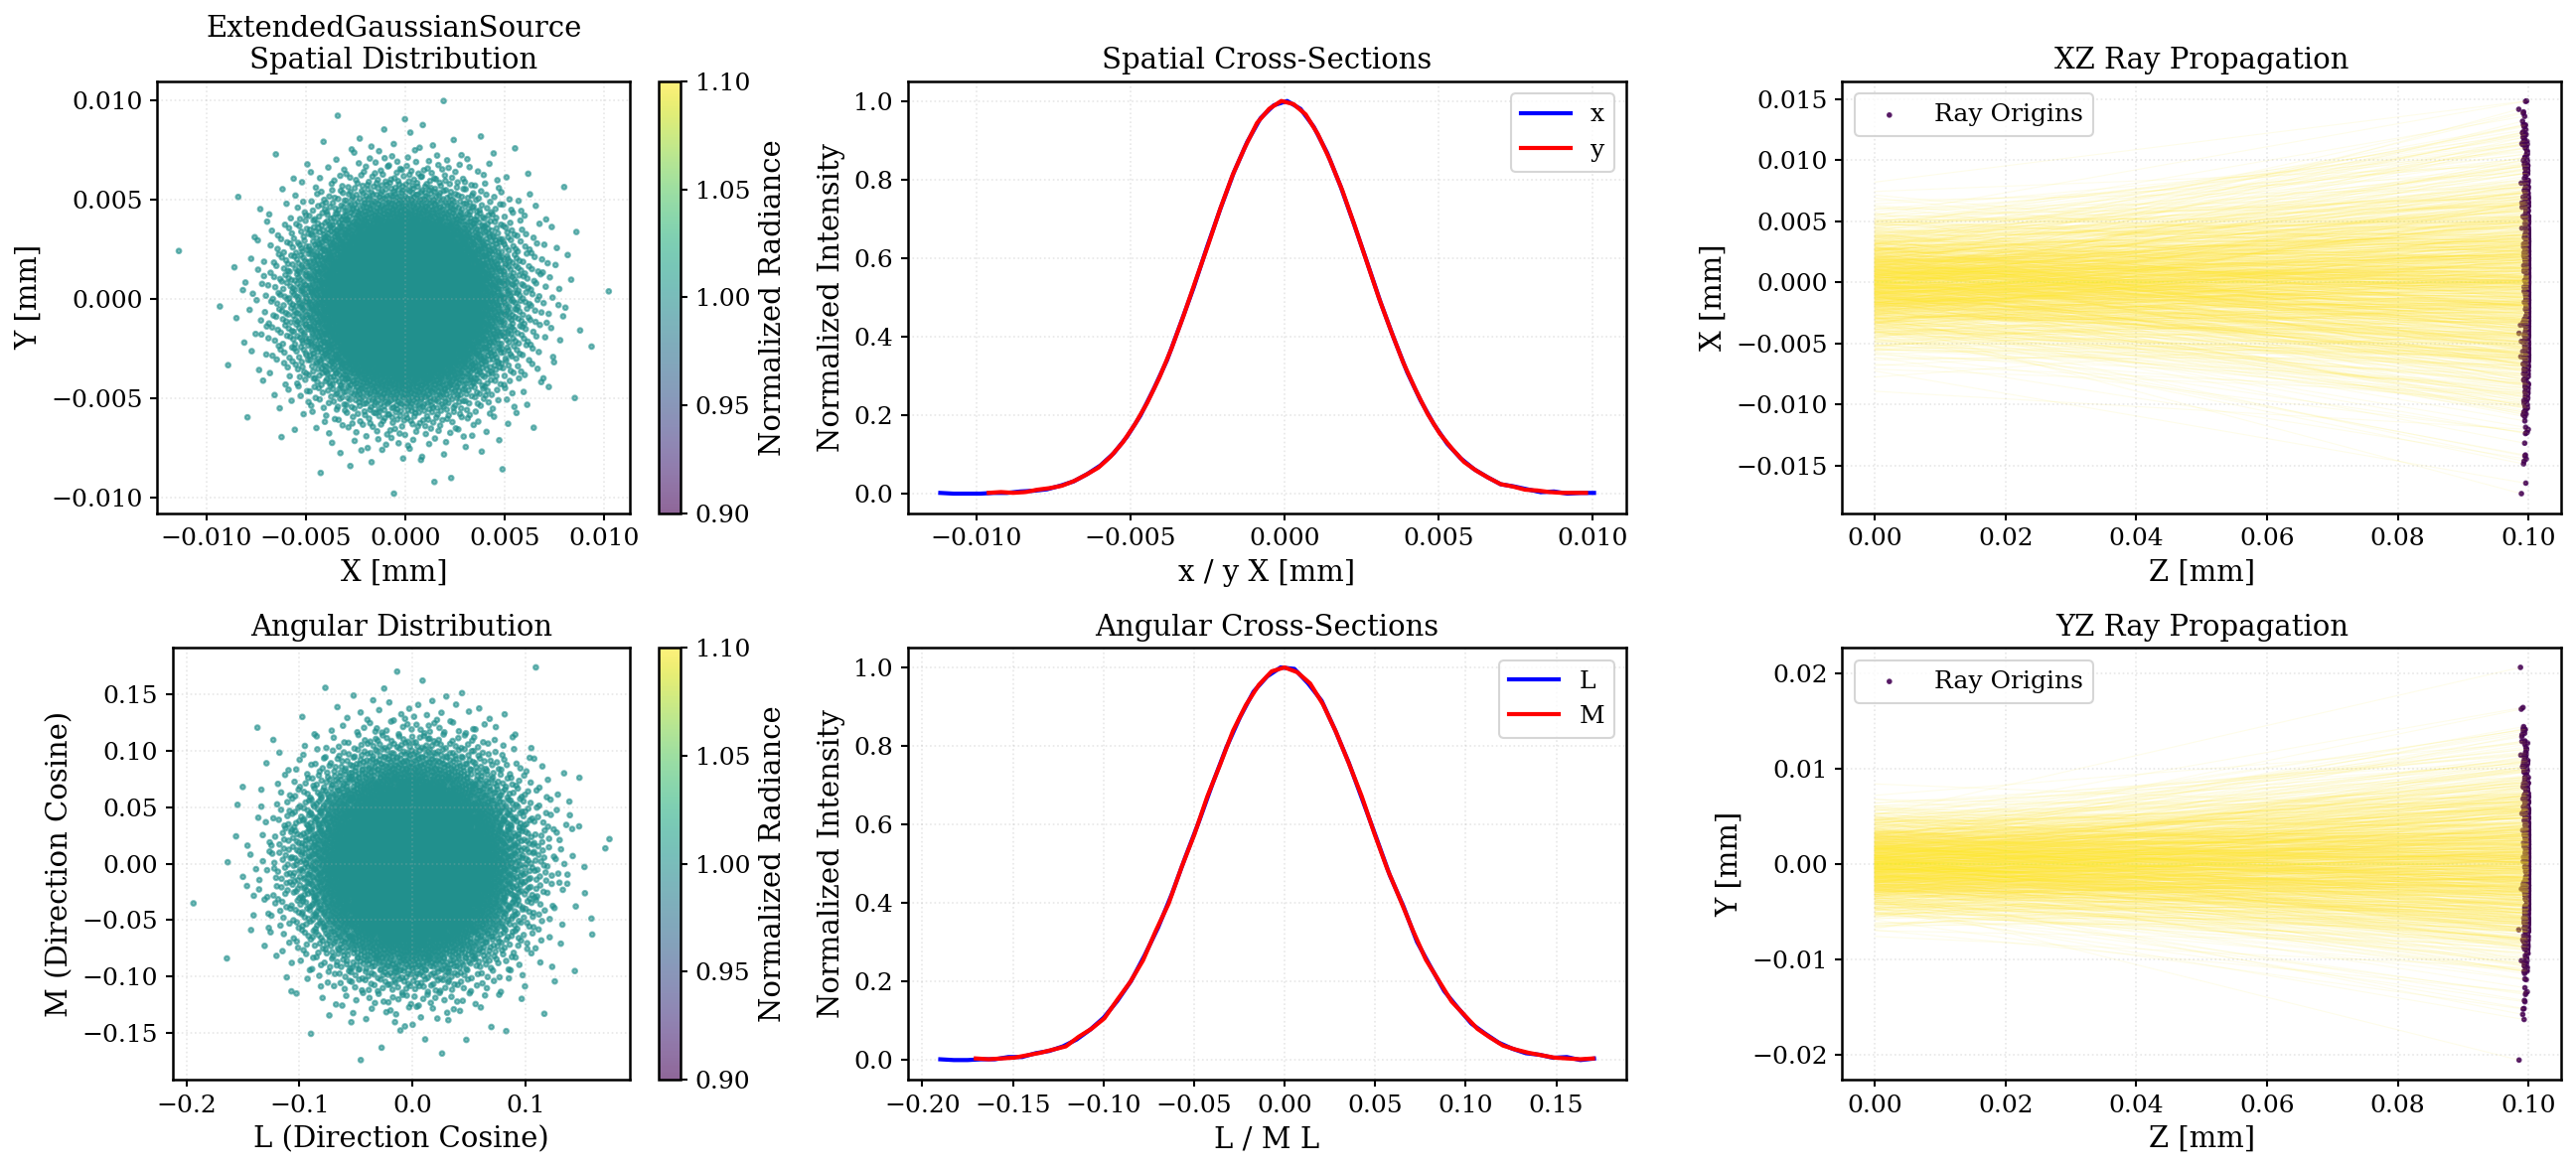

In [ ]:
source_ana = ExtendedGaussianSource(
    mfd_um=STD_EVAL["mfd_um"], # mode field diameter in µm = 2 * w0 = 10.4 µm
    divergence_deg_1_e2=STD_EVAL["divergence_deg_1_e2"], # full divergence angle (1/e²) in degrees = 10.87 deg
    wavelength_um=STD_EVAL["wavelength_um"], # wavelength in µm 
    device=DEVICE,
)

source_ana.draw(num_rays = 5000, propagation_distance=0.1,)

analysis_rays = source_ana.generate_rays(num_rays=int(STD_EVAL["num_analysis_rays"])) # 1e6 rays

### **Target**

In [ ]:
super_gaussian_target_ana = SuperGaussianIrradiance(
    peak_irradiance=STD_EVAL["peak_irradiance"],
    flattop_radius=STD_EVAL["top_hat_radius"], # 7.50 mm R0
    steepness=STD_EVAL["falloff_steepness"], # 16
    max_coord=STD_EVAL["top_hat_radius"] * 1.5, # 11.25 mm
    num_samples=int(STD_EVAL["num_bins_analysis"]), # 201
    backend='torch',
    device=DEVICE,
    )

# Already on the DEVICE
coords = super_gaussian_target_ana.coords
irr_target_ana = super_gaussian_target_ana.profile() # Already on the correct backend/device

assert isinstance(irr_target_ana, torch.Tensor) # tells both: runtime + type checker
assert isinstance(coords, torch.Tensor)

print(irr_target_ana.device)
print(coords.device) # cuda: 0 -> on GPU; cpu -> on CPU

cuda:0
cuda:0


### **Mask**

In [ ]:
# rigorous mask threshold copied from Manuel
ln_alpha = np.log(STD_EVAL["alpha_threshold"]) # ln(0.999) = -0.0010005
rho_thresh = STD_EVAL["top_hat_radius"] * (
        (-ln_alpha / 2.0) ** (1.0 / STD_EVAL["falloff_steepness"])
    )

rho_thresh_tensor = be.to_tensor(rho_thresh, device=DEVICE)

assert isinstance(coords, torch.Tensor)
assert isinstance(rho_thresh_tensor, torch.Tensor)

X, Y = torch.meshgrid(coords, coords, indexing="xy")
R = torch.sqrt(X**2 + Y**2)

mask_ana = torch.where(R <= rho_thresh, 1.0, 0.0) #.to(DEVICE)

print(mask_ana.device)
print(rho_thresh_tensor.device)

cuda:0
cuda:0


### **Summary**

In [ ]:
std_rays = analysis_rays

std_coords = coords 

std_target = irr_target_ana   

std_mask = mask_ana

std_rho_thresh = rho_thresh

# **Optimization**

## **Optimization Assets**

In [33]:
source_opt = ExtendedGaussianSource(
    mfd_um=STD_EVAL["mfd_um"], # mode field diameter in µm = 2 * w0 = 10.4 µm
    divergence_deg_1_e2=STD_EVAL["divergence_deg_1_e2"], # full divergence angle (1/e²) in degrees = 10.87 deg
    wavelength_um=STD_EVAL["wavelength_um"], # wavelength in µm 
    device=DEVICE,
)

optimization_rays = source_opt.generate_rays(num_rays=int(OPT_COMMON["num_optimization_rays"])) # 2**14=16384 rays required by Sobol sampling

super_gaussian_target_opt = SuperGaussianIrradiance(
    peak_irradiance=STD_EVAL["peak_irradiance"],
    flattop_radius=STD_EVAL["top_hat_radius"], # 7.50 mm R0
    steepness=STD_EVAL["falloff_steepness"], # 16
    max_coord=STD_EVAL["top_hat_radius"] * 1.5, # 11.25 mm
    num_samples=int(OPT_COMMON["num_bins_optimization"]), # 64
    backend='torch',
    device=DEVICE,
    )

target = super_gaussian_target_opt.profile() 

assert isinstance(target, torch.Tensor)

mask_opt= torch.where(
        target >= STD_EVAL["alpha_threshold"] * STD_EVAL["peak_irradiance"], 1.0, 0.0
    ).to(DEVICE)

Generated 16384 valid rays (from 16384 samples).


In [34]:
assert isinstance(std_target, torch.Tensor)

diff = (
    (
        std_mask
        - (std_target >= STD_EVAL["alpha_threshold"] * STD_EVAL["peak_irradiance"]).to(
            std_target.dtype
        )
    )
    .abs()
    .sum()
)
print("mask difference:", diff.item())

mask difference: 0.0


### **Summary**

In [35]:
opt_rays = optimization_rays

opt_coords = super_gaussian_target_opt.coords

opt_target = target

opt_mask = mask_opt

print(EPSILON)

1e-15


## **Loss Function**

In [ ]:
class Lossfunction:
    '''
    A class to compute loss functions for beam shaping optimization.
    
    by Manuel, modified by Ziyi Xiong 2026/1
    
    Args:
        sim_map (torch.Tensor): The simulated map.
        target_map (torch.Tensor): The target map.
    '''
    def __init__(self, sim_map: torch.Tensor, target_map: torch.Tensor):
        self.sim_map = sim_map
        self.target_map = target_map
        
    def rel_mse(self) -> torch.Tensor:
        '''
        Compute the relative mean squared error between the simulated map and the target map.
        '''
        numerator = torch.sum((self.sim_map - self.target_map) ** 2)
        denominator = torch.sum(self.target_map ** 2) + EPSILON  # Avoid division by zero
        rel_mse_value = numerator / denominator
        return rel_mse_value
    
    def uniformity(self, mask: torch.Tensor, reference_map: Optional[torch.Tensor] = None) -> torch.Tensor:
        '''
        Compute the uniformity metric of the simulated map within the target region.
        '''
        N = int(mask.sum().item())
        if N == 0:
            return torch.tensor(0.0, device=self.sim_map.device)
        ref = self.sim_map if reference_map is None else reference_map
        E_avg = (ref * mask).sum() / N
        if E_avg.item() <= EPSILON:
            return torch.tensor(0.0, device=self.sim_map.device)
        deviation = mask * (self.sim_map - E_avg)
        return torch.sum(deviation**2) / (N * (E_avg**2 + EPSILON))
    
    def mfg_sum_squared(self, model: OpticalSystemModule, active_indices: Optional[set] = None) -> torch.Tensor:
        '''
        Compute the sum of squared magnitudes of the model's 
        '''
        try:
            # Get the optic from the model
            optic = model.optic

            # Access the geometry object from the correct surface (index 2)
            geometry = optic.surface_group.surfaces[2].geometry

            # Get coefficients directly from the geometry
            if hasattr(geometry, "coeffs_c"):
                all_coeffs = geometry.coeffs_c

                # Ensure it's a tensor on the right device
                if not isinstance(all_coeffs, torch.Tensor):
                    # Convert to tensor if it's a dict or list
                    all_coeffs_list = (
                        list(all_coeffs.values())
                        if isinstance(all_coeffs, dict)
                        else all_coeffs
                    )
                    all_coeffs = torch.tensor(all_coeffs_list, device=DEVICE)

                # Filter only active coefficients if provided
                if active_indices is not None:
                    indices_list = sorted(list(active_indices))
                    valid_indices = [i for i in indices_list if i < len(all_coeffs)]

                    if not valid_indices:
                        return torch.tensor(0.0, device=DEVICE)

                    active_coeffs = all_coeffs[valid_indices]
                    return torch.sum(active_coeffs**2)
                else:
                    # Sum all coefficients if no active_indices provided
                    return torch.sum(all_coeffs**2)
            else:
                # Fallback to the old method if coeffs_c doesn't exist
                total = torch.tensor(0.0, device=DEVICE)
                for name, p in model.named_parameters():
                    if "forbes_qbfs_coeff" in name:
                        # last token should be idx
                        try:
                            idx = int(name.split(".")[-1])
                            if active_indices is None or idx in active_indices:
                                total = total + (p**2)
                        except ValueError:
                            continue
                return total
        except Exception as e:
            print(f"Warning in L_mfg_sum_squares: {e}")
            return torch.tensor(0.0, device=DEVICE)